IMPORT AND SETTINGS

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
import random

try:
    tf.config.experimental.enable_op_determinism()
    print("✅ Op Determinism Abilitato!")
except AttributeError:
    print("⚠️ Attenzione: La tua versione di TF è troppo vecchia per enable_op_determinism.")

def reset_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
SEEDS = [555]

DATASET LOADING AND MODELLING

In [ ]:
def load_dataset():
    folder='dataset/images'
    data=[]
    for filename in sorted(os.listdir(folder)):
        img_path=os.path.join(folder,filename)
        img=cv2.imread(img_path) #opencv save in bgr
        data.append({
            'image':img,
            'filename':filename
        })

    print(len(data),'images loaded')
    print('file name is: ',data[0]['filename'], 'shape of the image is:  ', data[0]['image'].shape )

    label=pd.read_csv('dataset/raw/bbx_annotations.csv')
    print(label.shape, label.iloc[0]['filename'])
    #images order is random, and for 1 image you can have more class

    print('we have', len(label['class'].unique()), 'different classes')

    #replace biggger img with half sized ones
    #cv2.imwrite('resize_image/last_img_pre_downsampling.jpg',data[-100]['image'])
    for i,item in enumerate(data):
        if "upper" in item["filename"].lower():
            data[i]['image']=cv2.resize(
                data[i]['image'],
                (data[i]['image'].shape[1]//2,data[i]['image'].shape[0]//2)
                ,interpolation=cv2.INTER_AREA
            )
    #cv2.imwrite('resize_image/last_img_post_downsampling.jpg',data[-100]['image'])
       
    return data, label

FROM THE PURE DATASET TO THE TRAIN AND TEST DATA AND LABEL

In [ ]:
def dataset_modelling(dataset,annotation):   
    dataset_df = pd.DataFrame(dataset) 
    label_map={'goalpost':0,
               'ball':1,
               'robot':2,
               'goalspot':3,
               'centerspot':4}
    def get_vector(classes_found):
        vec=np.zeros(5,dtype=int)

        for c in classes_found:
            if c in label_map:
                vec[label_map[c]]=1
        return list(vec)
    
    grouped = annotation.groupby('filename')['class'].apply(list).reset_index()
    grouped['label']=grouped['class'].apply(get_vector)
    final_annotation=grouped[['filename','label']]

    final_dataset= pd.merge(dataset_df, final_annotation[['filename', 'label']], on='filename', how='inner')
    final_dataset.to_csv('csv/temp/final_dataset.csv')
    final_dataset=final_dataset.drop(columns=['filename'])
    df_train, df_test = train_test_split(final_dataset, test_size=0.2, random_state=42)
    x_train = np.array(df_train['image'].tolist()).astype('float32') /255.0
    y_train = np.array(df_train['label'].tolist()).astype('float32')
    
    x_test = np.array(df_test['image'].tolist()).astype('float32') / 255.0
    y_test = np.array(df_test['label'].tolist()).astype('float32')
    return x_train, y_train,x_test,y_test
    

DOUBLING THE DATA 

In [ ]:
def augment_train_set(x_train,y_train):

    rng = np.random.RandomState(42)    
    
    x_flipped = np.flip(x_train, axis=2)
    y_flipped = y_train
    #---------------------------------#
    noise = rng.normal(loc=0.0, scale=0.05, size=x_train.shape)
    x_noisy = x_train + noise
    x_noisy = np.clip(x_noisy, 0., 1.)
    y_noise = y_train
    #--------------------------------#
    factors = rng.uniform(0.1, 0.3, size=(x_train.shape[0], 1, 1, 1))
    x_train_bright = np.clip(x_train + factors, 0.0, 1.0)
    #---------------------------------#
    contrast_fact = rng.uniform(0.8, 1.5, size=(x_train.shape[0], 1, 1, 1))
    mean = np.mean(x_train, axis=(1, 2), keepdims=True)
    x_contrast = (x_train - mean) * contrast_fact + mean
    x_contrast = np.clip(x_contrast, 0.0, 1.0)
    #--------------------------------#
    x_train_aug = np.concatenate([x_train,x_flipped, x_noisy,x_train_bright,x_contrast], axis=0)
    y_train_aug = np.concatenate([y_train,y_train, y_train,y_train,y_train], axis=0)

    #avoid to have all noisy data in validation--> shuffle
    indices = np.arange(x_train_aug.shape[0])
    rng.shuffle(indices)
    x_train_aug = x_train_aug[indices]
    y_train_aug = y_train_aug[indices]

    return x_train_aug, y_train_aug

MODEL BUILIDNG, 
kernel dimesnsion, pooling dimension, fc layers dimension, number of conv layer and learning rate have different combination.
instead, i fixed:
pooling stride=2 
pooling type: avg pooling
number of kernel per layer: 16, 32, 64...
last pooling: glob avg pool

In [ ]:
def build_model():
    model=models.Sequential()
    model.add(tf.keras.Input(shape=(240,320,3)))

    for i in range(4):
        kernel_number=16*(2**i)
        model.add(layers.Conv2D(kernel_number,(7,7),activation='elu',padding='same'))
        model.add(layers.AveragePooling2D((3,3),strides=2,padding='same'))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(5,activation='sigmoid'))

    #model.summary()
    return model


MAIN

In [ ]:
dataset, annotation=load_dataset()
x_train,y_train, x_test, y_test=dataset_modelling(dataset, annotation)
x_train,y_train=augment_train_set(x_train,y_train)

for seed in SEEDS:
    bestf1=0
    all_results = []

    print(f"\n ================== INIZIO CICLO CON SEED: {seed} ================== ")

    
    tf.keras.backend.clear_session()
    reset_seeds(seed)
    model=build_model()

    opt=tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=[tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        ])
    early_stop=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )
    reset_seeds(seed)
    #class_weights_dict=compute_class_weight(y_train)
    history=model.fit(
        x_train,y_train,
        epochs=120,
        batch_size=64, 
        validation_split=0.2, 
        callbacks=[early_stop]
        )

    y_pred=model.predict(x_test)
    predictions_binary = (y_pred > 0.5).astype(int)
    target_names = ['goalpost','ball','robot','goalspot','centerspot']
    report_dict = classification_report(y_test, predictions_binary, target_names=target_names, output_dict=True)
    f1_macro = report_dict['macro avg']['f1-score']
    

    df_report = pd.DataFrame(report_dict).transpose()
    df_report = df_report.round(2)
    df_report['support'] = df_report['support'].astype(int)
    csv_path = f'csv/report/report_data_aug_fnbctry_{seed}.csv'
    df_report.to_csv(csv_path)




FEATURES MAP

In [ ]:
def visualize_feature_maps(model, input_image):
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)
    img_batch = np.expand_dims(input_image, axis=0)
    activations = activation_model.predict(img_batch)
    images_per_row = 4
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1] 
        size_h = layer_activation.shape[1]     
        size_w = layer_activation.shape[2]
        n_features = min(n_features, 32) 
        n_cols = n_features // images_per_row
        
        if n_cols == 0: n_cols = 1 
        
        display_grid = np.zeros((size_h * n_cols, images_per_row * size_w))
        
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                
                channel_image -= channel_image.mean()
                channel_image /= (channel_image.std() + 1e-5) 
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                
                display_grid[col * size_h : (col + 1) * size_h,
                             row * size_w : (row + 1) * size_w] = channel_image

        # Plotting
        scale = 1. / size_h
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(f"Layer: {layer_name} ({n_features} feature maps)")
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.savefig(f'images/feature_map/data_aug_fnbC_64_{layer_name}.png', bbox_inches='tight', dpi=150)
        plt.show()
index_ball = np.where(y_test[:, 0] == 1)[0][30] 
img_to_test = x_test[index_ball]

visualize_feature_maps(model, img_to_test)



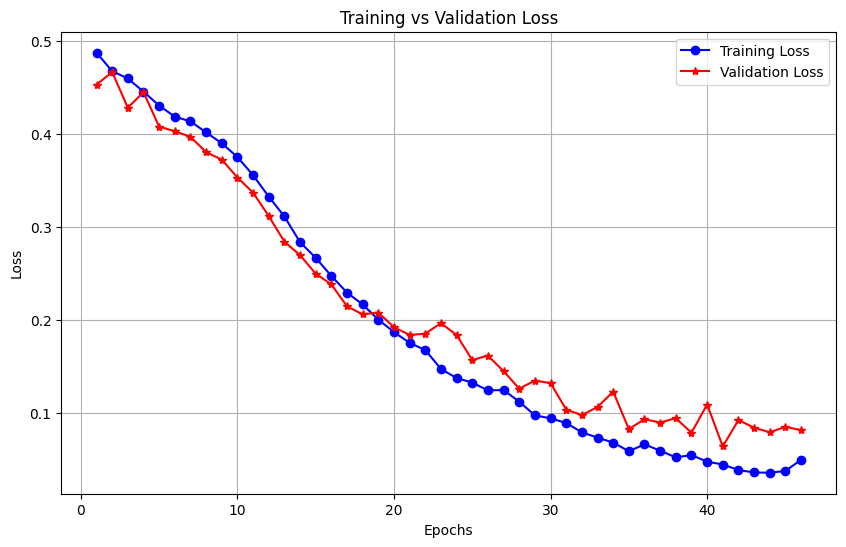

In [76]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 6))
    
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    
    plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
    
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.savefig('training_loss_plot.png')
    plt.show()


plot_loss(history)


SALIENCY MAP

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Probabilità predette: [5.0170557e-10 2.0912664e-08 1.0000000e+00 3.2286996e-01 2.9680210e-03]
Probabilità per la classe 4: 0.0029680209700018167


E0000 00:00:1765620381.187080 3598681 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


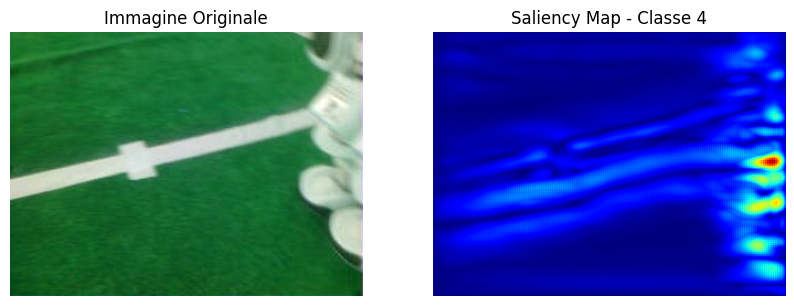

In [91]:
def visualize_saliency_logits(trained_model, input_image, class_index):


    model_logits = tf.keras.models.clone_model(trained_model)
    
    model_logits.layers[-1].activation = tf.keras.activations.linear
    
    model_logits.set_weights(trained_model.get_weights())
    
    img = tf.convert_to_tensor(input_image, dtype=tf.float32)
    if len(img.shape) == 3:
        img = tf.expand_dims(img, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(img)
        preds_logits = model_logits(img) 
        score = preds_logits[0, class_index]

    grads = tape.gradient(score, img)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=-1)[0]
    
    dgrad_max_ = (dgrad_max_ - dgrad_max_.min()) / (dgrad_max_.max() - dgrad_max_.min() + 1e-8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Immagine Originale")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(dgrad_max_, cmap='jet') 
    plt.title(f"Saliency Map - Classe {class_index}")
    plt.axis('off')
    plt.savefig(f'images/sal_map/saliency_map2_class_{class_index}.png')

    plt.show()
class_index=4
index_ball = np.where(y_test[:, class_index] == 1)[0][13] 
img_test = x_test[index_ball]
preds = model.predict(np.expand_dims(img_test, axis=0))
print(f"Probabilità predette: {preds[0]}")
print(f"Probabilità per la classe {class_index}: {preds[0][class_index]}")

visualize_saliency_logits(model, img_test, class_index)